# In this notebook, we use some simple models to see how the use of both EEG and EOG affect the results of the sleep classification

In [242]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
import os
import glob
import numpy as np
import gzip as gz
import pickle
from tqdm import tqdm
from transformers import AutoModel, AutoConfig
from torch.utils.data import TensorDataset, DataLoader, random_split
from BESTRq_classes.BESTRq import BestRqFramework, RandomProjectionQuantizer
from compute_fft import compute_spectrogram, plot_spectrogram, mask_and_replace
from models.CNN_BiLSTM_Attention import ParallelModel

# 1) Preparation of the pickle file, we need to compute it for every different set of data we want to study

For the moment let's only focus on the Sleep Cassette :
The 153 `SC*` files (SC = Sleep Cassette) were obtained in a 1987-1991 study of age effects on sleep in healthy Caucasians aged 25-101, without any sleep-related medication. Two PSGs of about 20 hours each were recorded during two subsequent day-night periods at the subjects homes. Subjects continued their normal activities but wore a modified Walkman-like cassette-tape.
Files are named in the form `SC4ssNEO-PSG.edf` where `ss` is the subject number, and `N` is the night. 

In [243]:
data_path = '/Users/martinblot/Desktop/sleep-edf-prepared/5-cassette'  ## path towards the 5-cassette file
fp = gz.open(data_path+'/SC4001E0.npz.gz','rb')
data_test = np.load(fp,allow_pickle=True)

x is separed into 4 different experiments : EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, EMG submental

We can then prepare the data for training and validation

In [244]:
fnames = glob.glob(os.path.join(data_path, "*npz.gz"))

In [245]:
devpart = 10
xtrain , xvalid = None , None
ytrain , yvalid = None , None
measurement=data_test['ch_label'][0:3]

for fn in tqdm(fnames):
    fp = gz.open(fn,'rb')
    data = np.load(fp,allow_pickle=False) # for now, don't care about headers
    x = data['x'][:,:,0:3] # EEG and EOG
    y = data['y'] # Take the labels
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    devlim = x.shape[0]//devpart
    devpart = 10
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    devlim = x.shape[0]//devpart
    if xtrain is None:
        xtrain = np.zeros((1,x.shape[1],3))    ##np.zeros((1,x.shape[1],2)) if we include EOG  
        xvalid = np.zeros((1,x.shape[1],3))
        ytrain , yvalid = np.zeros(1) , np.zeros(1)
    xvalid = np.concatenate((xvalid,x[idx[:devlim]]), axis=0)
    yvalid = np.concatenate((yvalid,y[idx[:devlim]]), axis=0)
    xtrain = np.concatenate((xtrain,x[idx[devlim:]]), axis=0)
    ytrain = np.concatenate((ytrain,y[idx[devlim:]]), axis=0)
    del x,y

100%|██████████| 153/153 [02:39<00:00,  1.04s/it]


In [246]:
print(xtrain.shape,ytrain.shape,xvalid.shape,yvalid.shape)

(175996, 600, 3) (175996,) (19485, 600, 3) (19485,)


In [247]:
# clean the first dummy example
xtrain , xvalid = xtrain[1:] , xvalid[1:]
ytrain , yvalid = ytrain[1:] , yvalid[1:]
print(xtrain.shape, xvalid.shape)

(175995, 600, 3) (19484, 600, 3)


In [248]:
# In Torch version
xtrain, xvalid = th.FloatTensor(xtrain), th.FloatTensor(xvalid)
ytrain, yvalid = th.IntTensor(ytrain), th.IntTensor(yvalid)

Store data as a pickle file : to do only ONCE

In [251]:
outf="/Users/martinblot/Desktop/sleep-edf-prepared/cassette-th-data-all.pck"
fp = open(outf,"wb")
pickle.dump((xtrain , xvalid , ytrain , yvalid), fp)

# 2) Open the pickle file : reuse this in a code to train a model

In [260]:
filepath = '/Users/martinblot/Desktop/sleep-edf-prepared/cassette-th-data-all.pck'
xtrain,xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
print(xtrain.shape)


torch.Size([175995, 600, 3])


Plot the data and visualize to what stage of sleep it corresponds

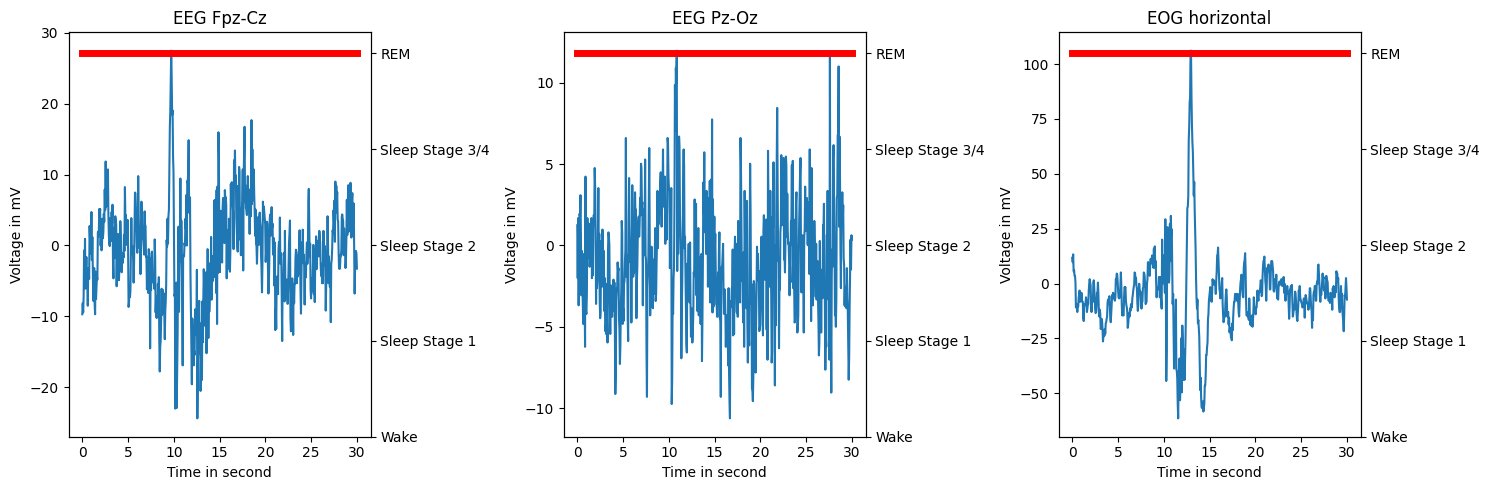

In [262]:
numero_analyse=150
time=np.linspace(0,30,xtrain.shape[1])

# Créer une figure avec 3 sous-tracés côte à côte
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1
ax1.plot(time, xtrain[numero_analyse,:,0])
ax1.set_xlabel('Time in second')
ax1.set_ylabel('Voltage in mV')
ax1.set_title(measurement[0])
# Twin axes for ax1
ax1_2 = ax1.twinx()
ax1_2.plot(time, ytrain[numero_analyse]*np.ones(time.shape), color='red', linewidth=5)
ax1_2.set_yticks([0, 1, 2, 3, 4])
ax1_2.set_yticklabels(['Wake', 'Sleep Stage 1', 'Sleep Stage 2', 'Sleep Stage 3/4', 'REM'], fontsize=10)

# Plot 2
ax2.plot(time, xtrain[numero_analyse,:,1])
ax2.set_xlabel('Time in second')
ax2.set_ylabel('Voltage in mV')
ax2.set_title(measurement[1])
# Twin axes for ax2
ax2_2 = ax2.twinx()
ax2_2.plot(time, ytrain[numero_analyse]*np.ones(time.shape), color='red', linewidth=5)
ax2_2.set_yticks([0, 1, 2, 3, 4])
ax2_2.set_yticklabels(['Wake', 'Sleep Stage 1', 'Sleep Stage 2', 'Sleep Stage 3/4', 'REM'], fontsize=10)

# Plot 3
ax3.plot(time, xtrain[numero_analyse,:,2])
ax3.set_xlabel('Time in second')
ax3.set_ylabel('Voltage in mV')
ax3.set_title(measurement[2])
# Twin axes for ax3
ax3_2 = ax3.twinx()
ax3_2.plot(time, ytrain[numero_analyse]*np.ones(time.shape), color='red', linewidth=5)
ax3_2.set_yticks([0, 1, 2, 3, 4])
ax3_2.set_yticklabels(['Wake', 'Sleep Stage 1', 'Sleep Stage 2', 'Sleep Stage 3/4', 'REM'], fontsize=10)

# Afficher la figure
plt.tight_layout()
plt.show()

Now we have understand everything about the data we can compute some models to train !

# 3) Training a basic model

In [263]:
#from models import CNN_3D

In [361]:
class SimplifiedCNN_2D(nn.Module):
    def __init__(self, dropout_prob=0.25):
        super(SimplifiedCNN_2D, self).__init__()
        self.dropout_prob = dropout_prob
        
        # Convolutional block
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=self.dropout_prob),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=self.dropout_prob),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=self.dropout_prob),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=self.dropout_prob)
        )
        # Softmax layer
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # Forward pass through convolutional block
        x = self.conv_block(x)
        
        # Apply softmax
        x = self.softmax(x)
        
        return x

In [362]:
model=SimplifiedCNN_2D(0.25)

In [363]:
xtrain.shape

torch.Size([175995, 600, 3])

In [364]:
xtrain_tensor,ytrain_tensor=th.tensor(xtrain[:1000]),th.tensor(ytrain[:1000])
xvalid_tensor,yvalid_tensor=th.tensor(xvalid[:1000]),th.tensor(yvalid[:1000])

dataset_t = TensorDataset(xtrain_tensor, ytrain_tensor)
train_loader = DataLoader(dataset_t, batch_size= 100, shuffle=True)
dataset_v = TensorDataset(xvalid_tensor, yvalid_tensor)
valid_loader = DataLoader(dataset_v, batch_size= 100, shuffle=True)

/var/folders/4d/0mw5kdt55tl7r35rc_2wqkph0000gn/T/ipykernel_47102/2719476002.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtrain_tensor,ytrain_tensor=th.tensor(xtrain[:1000]),th.tensor(ytrain[:1000])
/var/folders/4d/0mw5kdt55tl7r35rc_2wqkph0000gn/T/ipykernel_47102/2719476002.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xvalid_tensor,yvalid_tensor=th.tensor(xvalid[:1000]),th.tensor(yvalid[:1000])


In [365]:
# Listes pour stocker les valeurs de perte et de précision
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Listes pour stocker les valeurs de perte et de précision
train_losses = []
val_losses = []
val_accuracies = []

# Entraînement et validation du modèle
num_epochs = 30
for epoch in range(num_epochs):
    total_train_correct = 0.0
    total_train_samples = 0.0
    train_loss = 0.0
    total_val_correct = 0.0
    total_val_samples = 0.0
    val_loss = 0.0
    # Entraînement
    model.train()  # Mettre le modèle en mode d'entraînement
    for inputs, labels in train_loader:
        inputs=inputs.transpose(2,0).unsqueeze(0)
        print(inputs.shape)
        labels=labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Calculer le nombre total de prédictions correctes
        _, predicted = th.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)
        
        # Collecter la perte pour l'époque
        train_loss += loss.item()
    
    # Calculer la précision et la perte moyenne d'entraînement
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation
    model.eval()  # Mettre le modèle en mode d'évaluation
    with th.no_grad():
        for inputs_val, labels_val in valid_loader:
            outputs_val = model(inputs_val)
            val_loss += criterion(outputs_val, labels_val.to(int)).item()
            
            # Calculer le nombre total de prédictions correctes
            _, predicted_val = th.max(outputs_val, 1)
            total_val_correct += (predicted_val == labels_val).sum().item()
            total_val_samples += labels_val.size(0)
    
    # Calculer la précision et la perte moyenne de validation
    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = total_val_correct / total_val_samples
    
    # Ajouter les valeurs à nos listes
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Afficher les résultats de l'époque
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}')

# Tracer les courbes de perte et de précision
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution de la perte pendant l\'entraînement')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolution de la précision pendant l\'entraînement')
plt.legend()
plt.show()

torch.Size([1, 3, 600, 100])


ValueError: Expected input batch_size (1) to match target batch_size (100).

# 4) Computing the FFT thanks to the compute_fft.py method : to continue

In [159]:
spectrogram=compute_spectrogram(xtrain,n_fft=1000)
spectrogram.shape

torch.Size([175995, 501, 13])

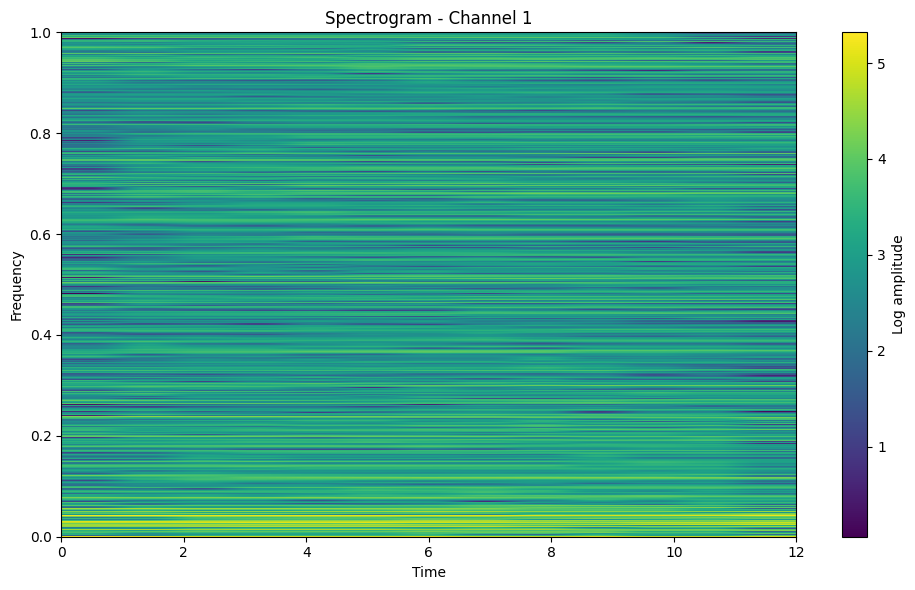

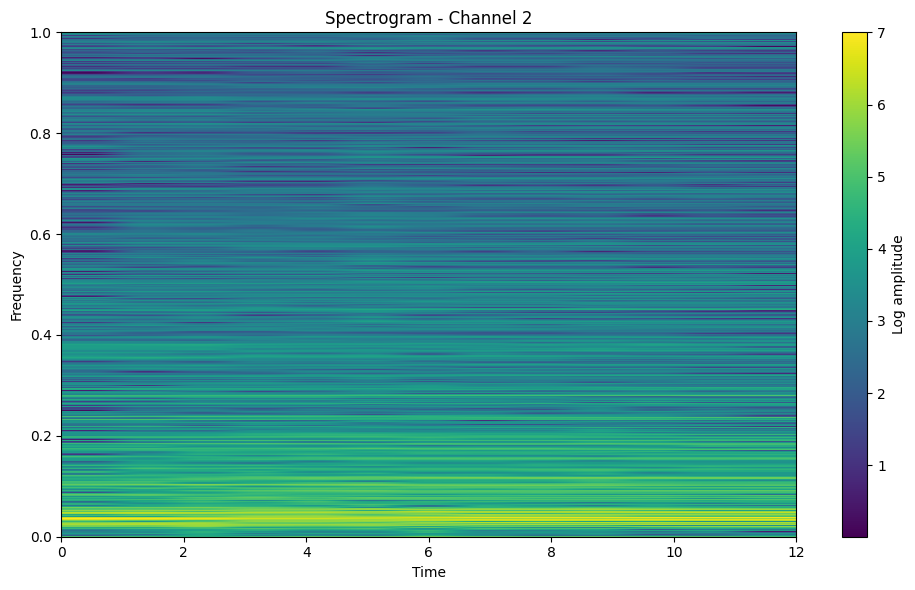

In [162]:
plot_spectrogram(spectrogram[0:2], sample_rate=1, title='Spectrogram', xlabel='Time', ylabel='Frequency')